In [1]:
# from Semantic Segmentation using PyTorch FCN ResNet50 tutorial https://debuggercafe.com/semantic-segmentation-using-pytorch-fcn-resnet/

In [2]:
# connecting drive to colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# assigning a different color map tuple (RGB format) to each class.
label_color_map = [
               (0, 0, 0),  # background
               (128, 0, 0), # aeroplane
               (0, 128, 0), # bicycle
               (128, 128, 0), # bird
               (0, 0, 128), # boat
               (128, 0, 128), # bottle
               (0, 128, 128), # bus 
               (128, 128, 128), # car
               (64, 0, 0), # cat
               (192, 0, 0), # chair
               (64, 128, 0), # cow
               (192, 128, 0), # dining table
               (64, 0, 128), # dog
               (192, 0, 128), # horse
               (64, 128, 128), # motorbike
               (192, 128, 128), # person
               (0, 64, 0), # potted plant
               (128, 64, 0), # sheep
               (0, 192, 0), # sofa
               (128, 192, 0), # train
               (0, 64, 128) # tv/monitor
]

In [4]:
import torchvision.transforms as transforms
import cv2
import numpy as np
import numpy
import torch

# converting all the images to tensors and then normalize them

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# give the model an image as input, forward pass through the image and provide us with the Ordered Dictionary output
def get_segment_labels(image, model, device):
    # transform the image to tensor and load into computation device
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image)
    # uncomment the following lines for more info
    # print(type(outputs))
    # print(outputs['out'].shape)
    # print(outputs)
    return outputs

# apply the color masks to outputs
def draw_segmentation_map(outputs):
    labels = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
    red_map = np.zeros_like(labels).astype(np.uint8)
    green_map = np.zeros_like(labels).astype(np.uint8)
    blue_map = np.zeros_like(labels).astype(np.uint8)
    
    for label_num in range(0, len(label_color_map)):
        index = labels == label_num
        red_map[index] = np.array(label_color_map)[label_num, 0]
        green_map[index] = np.array(label_color_map)[label_num, 1]
        blue_map[index] = np.array(label_color_map)[label_num, 2]
        
    segmented_image = np.stack([red_map, green_map, blue_map], axis=2)
    return segmented_image

# overlay segmented image with the image
def image_overlay(image, segmented_image):
    alpha = 0.6 # how much transparency to apply
    beta = 1 - alpha # alpha + beta should equal 1
    gamma = 0 # scalar added to each sum
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    cv2.addWeighted(segmented_image, alpha, image, beta, gamma, image)
    return image

In [ ]:
import torchvision
import numpy
import torch
import argparse
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow

from torchvision.io.image import read_image
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image

# Initialize model with the best available weights
# create an instance of (e.g.) torchvision.models.segmentation.fcn_resnet50
# and tell it to load pretrained weights
weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights)
# set computation device
device = torch.device('cuda')
# model to eval() model and load onto computation devicce
model.eval().to(device)

### Testing on an image

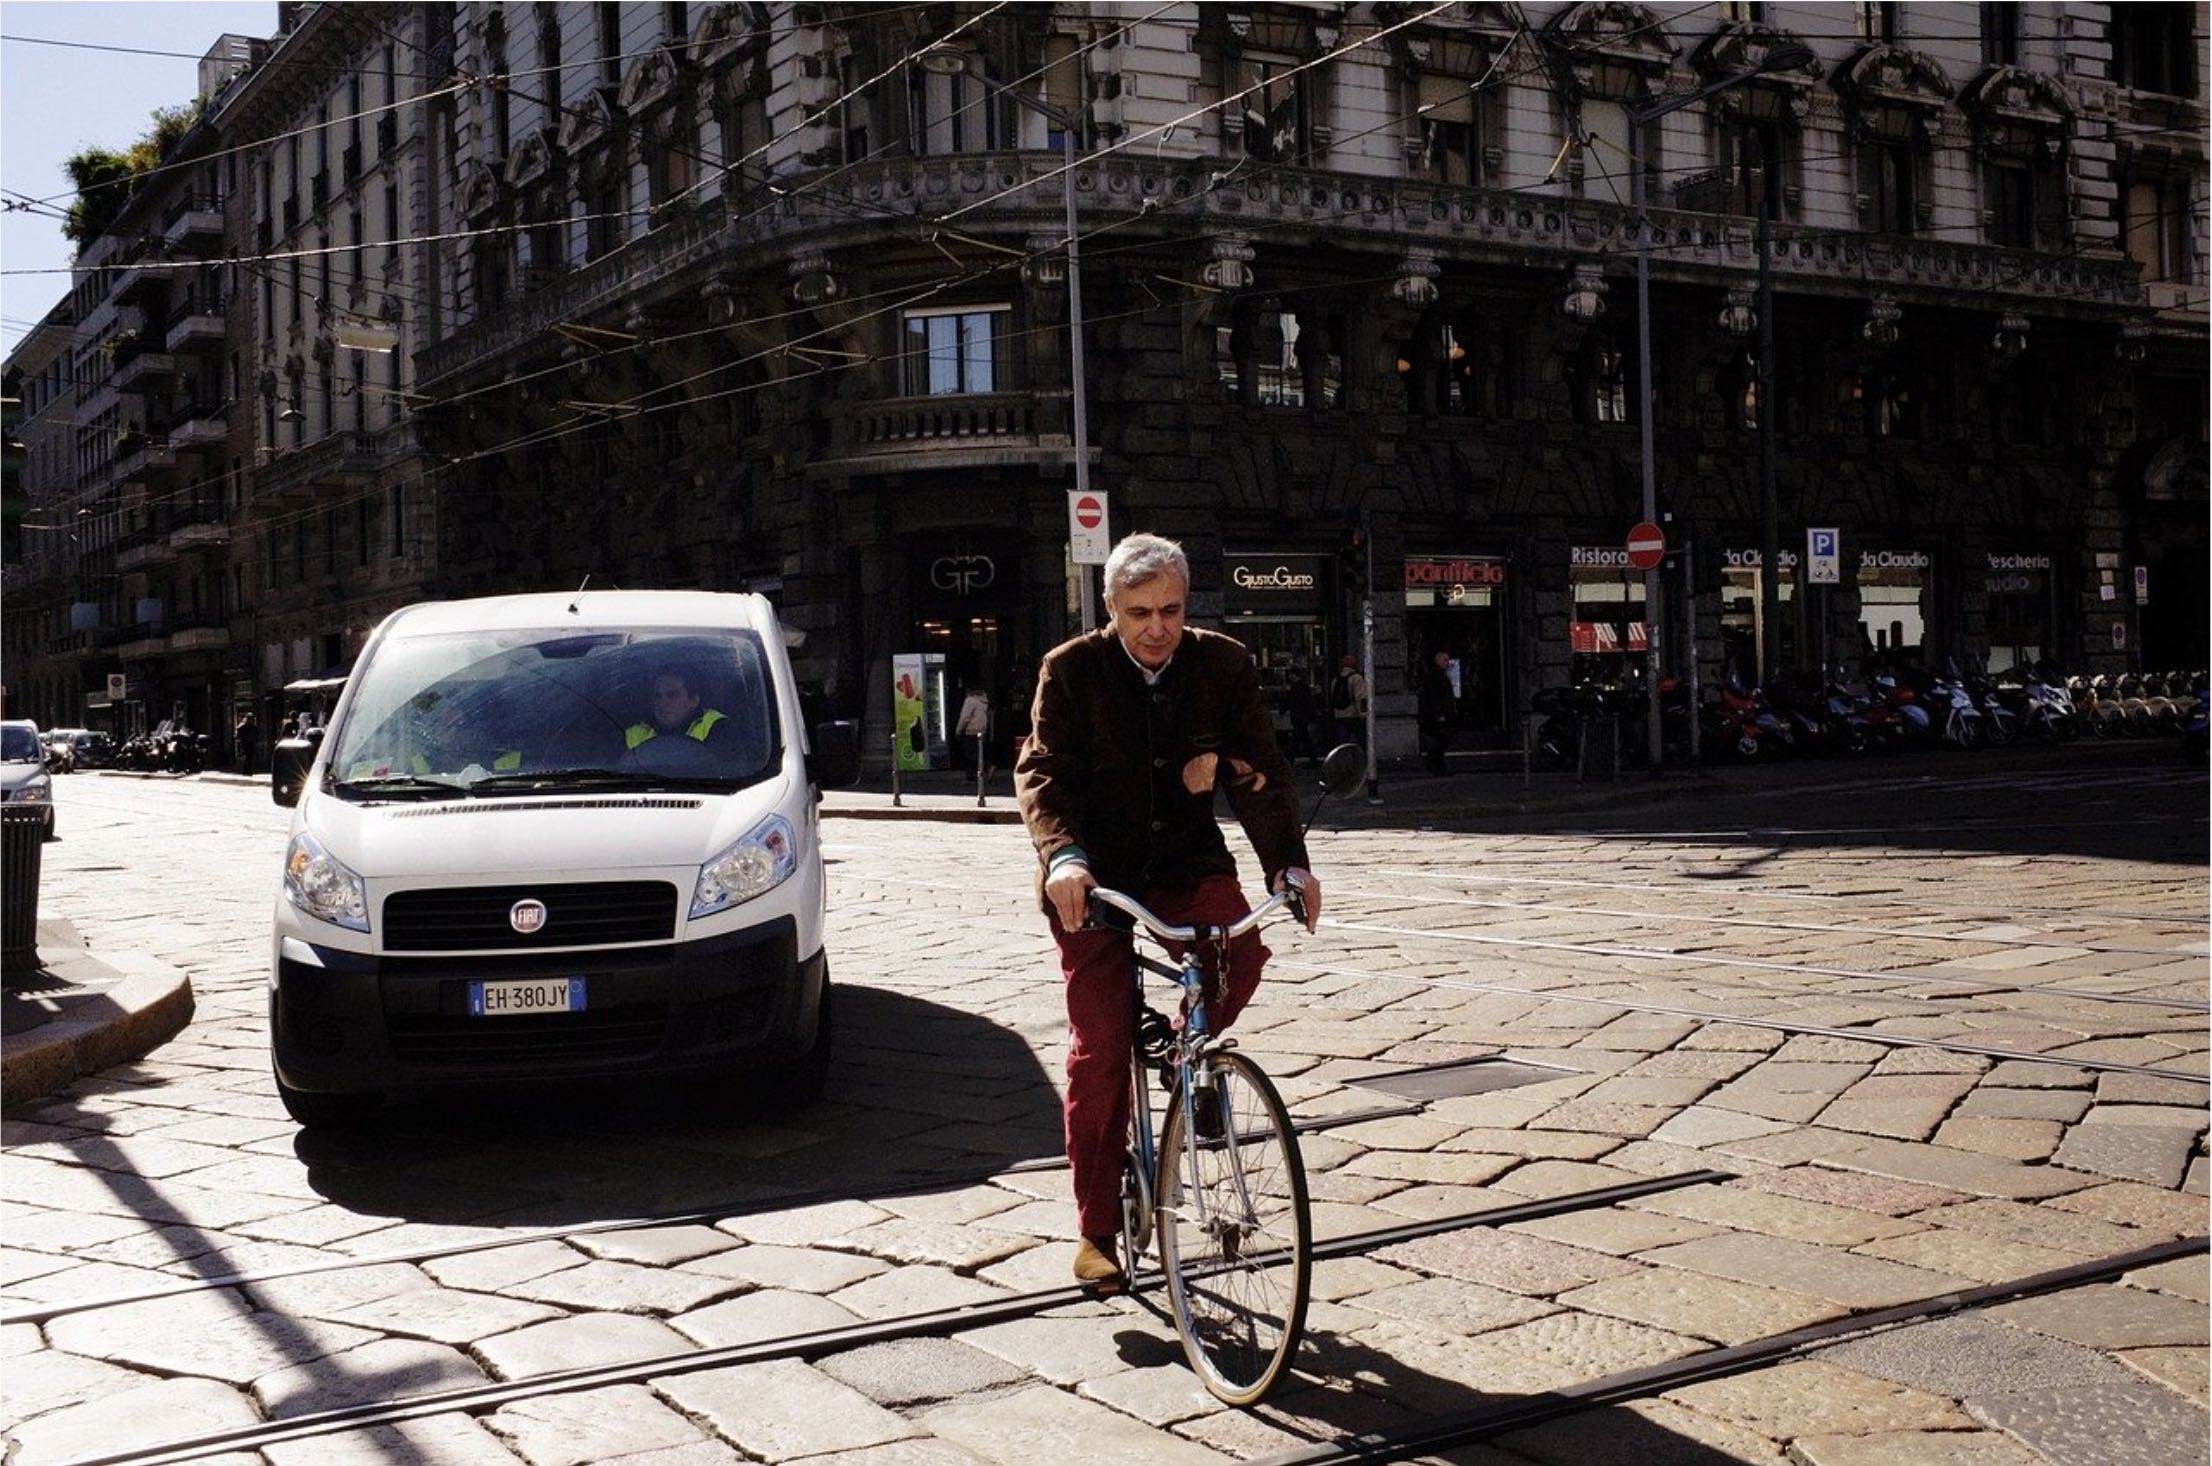

In [ ]:
# read the image
image = Image.open('/content/drive/MyDrive/img_test/image_for_segmentation.jpg')
display(image)

In [ ]:
# do forward pass and get the output dictionary
outputs = get_segment_labels(image, model, device)
# get the data from the `out` key
outputs = outputs['out']
segmented_image = draw_segmentation_map(outputs)

final_image = image_overlay(image, segmented_image)

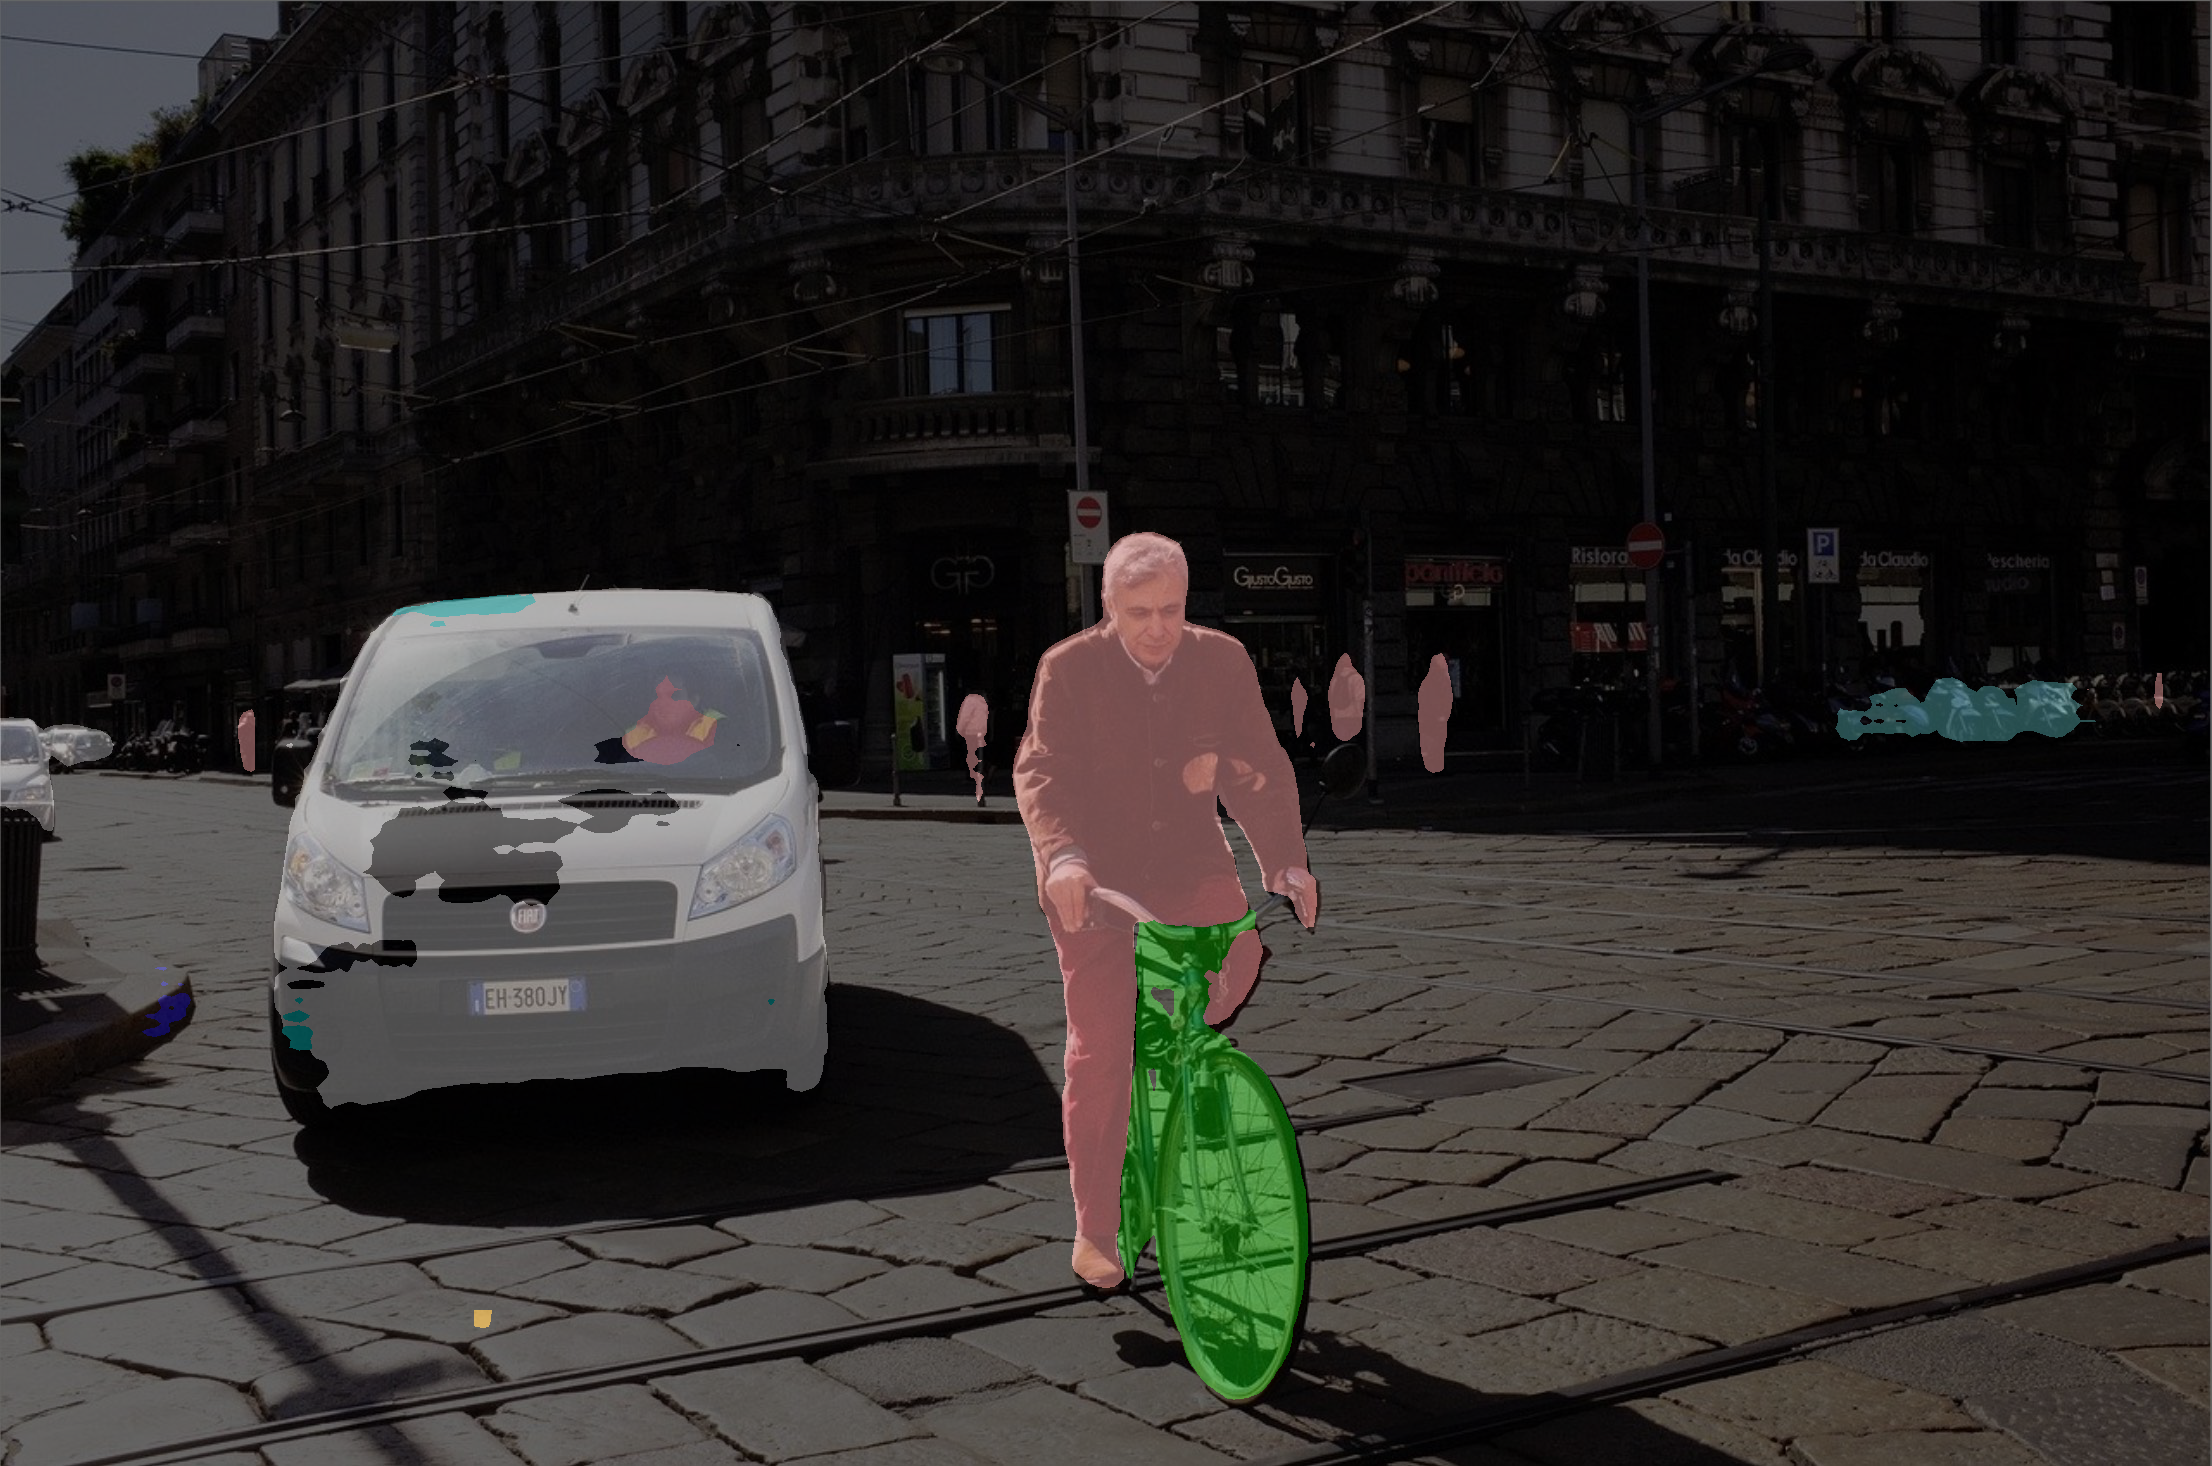

In [ ]:
# show the segmented image
cv2_imshow(final_image)

### Testing on image from our training data

In [6]:
# unziping frames into data folder
!unzip -d "test_training_data"/ /content/drive/MyDrive/test_training_data.zip

Archive:  /content/drive/MyDrive/test_training_data.zip
   creating: test_training_data/content/training_data/
  inflating: test_training_data/content/training_data/Tai chiRen Guang Yi - Chen Style Taiji silk reeling part II-Wh3AmDsdQtM.npz  


In [ ]:
from numpy import load
import matplotlib.pyplot as plt

data = load('test_training_data/content/training_data/Tai chiRen Guang Yi - Chen Style Taiji silk reeling part II-Wh3AmDsdQtM.npz', allow_pickle=True)
lst = data.files
for item in lst:
  for x in range(len(item)):
    if x==0:
      test_image = Image.fromarray(data[item][x][0])
    plt.imshow(data[item][x][0])
    plt.show()
    plt.imshow(data[item][x][1])
    plt.show()
    print(data[item][x][2])

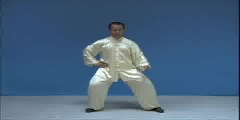

In [9]:
display(test_image)

In [10]:
# do forward pass and get the output dictionary
outputs = get_segment_labels(test_image, model, device)
# get the data from the `out` key
outputs = outputs['out']
segmented_image = draw_segmentation_map(outputs)

final_image = image_overlay(test_image, segmented_image)

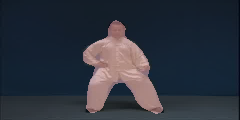

torch.Size([1, 21, 120, 240])

In [36]:
# show the segmented image
cv2_imshow(final_image)

## Modifying the prediction model

In [62]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [75]:
import torch.nn as nn
from collections import OrderedDict
import torch.optim as optim

modified_model = fcn_resnet50(weights=weights)
# set computation device
device = torch.device('cuda')
modified_model.train().to(device)
# we are feature extracting so we only need to compute weights for the new layer
set_parameter_requires_grad(modified_model, True)

In [76]:
# modify that model slightly, by removing its final layer and replacing
# with a 2D vector output at each pixel(?) (instead of 20 class logits)

# (classifier): FCNHead(
#     (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#     (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     (2): ReLU()
#     (3): Dropout(p=0.1, inplace=False)
#     (4): Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))
#   )
# (aux_classifier): FCNHead(
#     (0): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
#     (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#     (2): ReLU()
#     (3): Dropout(p=0.1, inplace=False)
#     (4): Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
#   )
# )

my_classifier = nn.Sequential(OrderedDict([
    ('0', nn.Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
    ('1', nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
    ('2', nn.ReLU()),
    ('3', nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1)))
]))

my_aux_classifier = nn.Sequential(OrderedDict([
    ('0', nn.Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)),
    ('1', nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
    ('2', nn.ReLU()),
    ('3', nn.Conv2d(216, 2, kernel_size=(1, 1), stride=(1, 1)))
]))


# instead of torch.Size([1, 21, 120, 240]) -> torch.Size([1, 2, 120, 240])
modified_model.classifier = my_classifier
modified_model.aux_classifier = my_aux_classifier
print(modified_model)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [80]:
# see what parameters will be tuned
params_to_update = modified_model.parameters()
print('Params to learn:')
for name, param in modified_model.named_parameters():
  if param.requires_grad:
      print(name)

Params to learn:
classifier.0.weight
classifier.1.weight
classifier.1.bias
classifier.3.weight
classifier.3.bias
aux_classifier.0.weight
aux_classifier.1.weight
aux_classifier.1.bias
aux_classifier.3.weight
aux_classifier.3.bias


In [ ]:
# define train function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_aux=False):
  since = time.time()

  val_acc_history = []

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0 # shall we have in our case?

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_aux and phase == 'train': 
                      outputs, aux_outputs = model(inputs) # should we use aux? this is from inception model, aux works differently in fcn resnet
                      loss1 = criterion(outputs, labels)
                      loss2 = criterion(aux_outputs, labels)
                      loss = loss1 + 0.4*loss2
                    else:
                      outputs = model(inputs)
                      loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

            print()
            
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # load best model weights
        model.load_state_dict(best_model_wts)
        return model, val_acc_history


In [ ]:
# define dataloader
# and load data
dataloaders_dict = []

In [78]:
batch_size = 8
num_epochs = 15

# define optimizer
my_optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss
my_criterion = nn.CrossEntropyLoss()

# Train and evaluate
modified_model, hist = train_model(modified_model,
                                   dataloaders_dict,
                                   my_criterion,
                                   my_optimizer,
                                   num_epochs=num_epochs)

In [33]:
def get_output(image, model, device):
  image = transform(image).to(device)
  image = image.unsqueeze(0) # add a batch dimension
  output = model(image)
  return output

In [ ]:
output = get_output(test_image, modified_model, device)
print(output['out'].shape)